In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import minimize

In [2]:
data = pd.read_csv("E:/Projects/AGN_mass_project/data/cassianiga_2013.csv")
data = data.loc[:]

In [3]:
MgII_alpha_beta_list = [(1.70,0.63,'S11'),                        # First tuple= By Shen 2011 (S11)
                        (0.505,0.62,'MD04'),                      # second tuple= By Mclure Dunlop (MD04)
                        (0.86,0.5,'VO09'),                        # Third tuple= By Vestergaard & Osmer 2009 (VO09)
                        (0.74,0.62,'S10')]                       # Fourth tuple= By Yue Shen (S10)

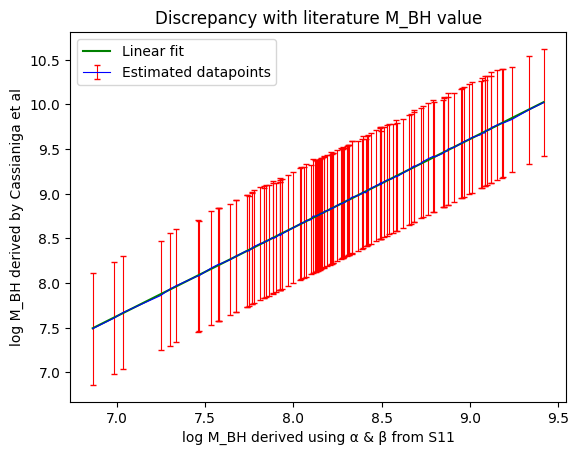

     This_work  Cassianiga_2013  Difference
12      6.8621             7.49      0.6279
142     6.9845             7.61      0.6255
47      7.0343             7.67      0.6357
78      7.2464             7.86      0.6136
2       7.2977             7.93      0.6323
..         ...              ...         ...
134     9.1810             9.79      0.6090
28      9.1881             9.79      0.6019
35      9.2376             9.83      0.5924
13      9.3355             9.94      0.6045
32      9.4182            10.02      0.6018

[122 rows x 3 columns]
Mean relative error in predictions: 0.618090983606557


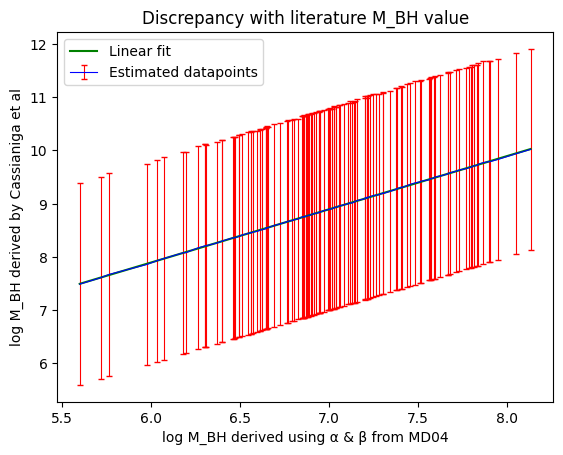

     This_work  Cassianiga_2013  Difference
12      5.6004             7.49      1.8896
142     5.7180             7.61      1.8920
47      5.7632             7.67      1.9068
78      5.9786             7.86      1.8814
2       6.0348             7.93      1.8952
..         ...              ...         ...
134     7.8990             9.79      1.8910
28      7.9044             9.79      1.8856
35      7.9474             9.83      1.8826
13      8.0520             9.94      1.8880
32      8.1318            10.02      1.8882

[122 rows x 3 columns]
Mean relative error in predictions: 1.8949622950819673


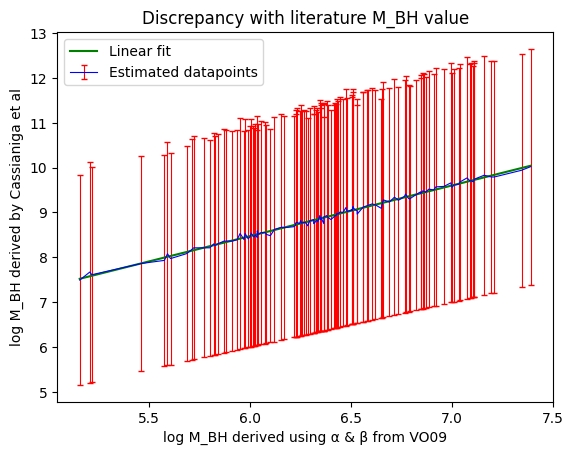

     This_work  Cassianiga_2013  Difference
12       5.155             7.49       2.335
47       5.205             7.67       2.465
142      5.215             7.61       2.395
78       5.460             7.86       2.400
2        5.575             7.93       2.355
..         ...              ...         ...
35       7.160             9.83       2.670
28       7.195             9.79       2.595
134      7.210             9.79       2.580
13       7.345             9.94       2.595
32       7.390            10.02       2.630

[122 rows x 3 columns]
Mean relative error in predictions: 2.522418032786885


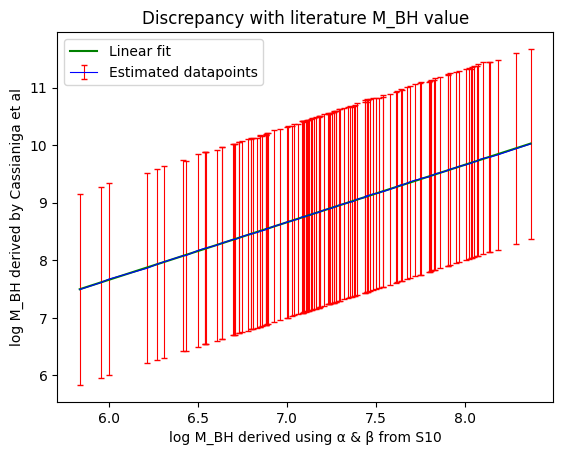

     This_work  Cassianiga_2013  Difference
12      5.8354             7.49      1.6546
142     5.9530             7.61      1.6570
47      5.9982             7.67      1.6718
78      6.2136             7.86      1.6464
2       6.2698             7.93      1.6602
..         ...              ...         ...
134     8.1340             9.79      1.6560
28      8.1394             9.79      1.6506
35      8.1824             9.83      1.6476
13      8.2870             9.94      1.6530
32      8.3668            10.02      1.6532

[122 rows x 3 columns]
Mean relative error in predictions: 1.659962295081967
Optimal alpha and beta values are: [2.40023327 0.61996652]


In [4]:
for i in range(len(MgII_alpha_beta_list)):
    alpha= MgII_alpha_beta_list[i][0]
    beta= MgII_alpha_beta_list[i][1]
    alpha_beta_taken_from = MgII_alpha_beta_list[i][2]
    gamma = 2
    df = pd.DataFrame({'L': data['logL30'], 'FWHM': data['logWMg']})   # Here L3000 column is actually Log λLλ at 3000 Å, and WMgII column is the FWHM (full width at half maximum)



    df['L'] = pd.to_numeric(df['L'], errors='coerce')   
    df['FWHM'] = pd.to_numeric(df['FWHM'], errors='coerce')
    df = df.dropna(subset=['L', 'FWHM'])
    L = 7+ df['L']   # this 7 is added as the values in data are given in the units 10^-7 W, so we want to convert it into erg/s. So we need to multiply by 10^7, but since this value is going to be used as a power, we add 7 instead of multiplying.
    FWHM = 10**(df['FWHM'])   # Here we needed to convert log (WMg) into WMg, so we did 10^(logWMg)


    def log_M_BH(alpha,beta,gamma,L,FWHM):      
        return alpha + np.log10(10**L/1e44)*beta + np.log10(FWHM/1000)*gamma    # As L values were originally in log, we took antilog here by doing 10^L
    
    log_M_BH_array = np.zeros(len(L))


    for index,value in enumerate(log_M_BH(alpha,beta,gamma,L,FWHM)):
        log_M_BH_array[index]= value


    plot_df = pd.DataFrame({'This_work': log_M_BH_array, 'Cassianiga_2013': data['logMMg'][df.index].astype(float)})   # Here We make sure masses predicted by us and Cassianiga are aligned for each object by index selection.
    plot_df = plot_df.sort_values(['This_work', 'Cassianiga_2013'], ascending=[True, True])
    y_err = abs(plot_df['Cassianiga_2013']-plot_df['This_work'])

    result = stats.linregress(plot_df['This_work'],plot_df['Cassianiga_2013'])


    plt.xlabel(f'log M_BH derived using α & β from {alpha_beta_taken_from}')
    plt.ylabel('log M_BH derived by Cassianiga et al')
    plt.title('Discrepancy with literature M_BH value')
    plt.errorbar(x=plot_df['This_work'], y=plot_df['Cassianiga_2013'], yerr=y_err,color='blue', ecolor='red',lw=0.8,capsize=2,label='Estimated datapoints')
    plt.plot(plot_df['This_work'], result.intercept + result.slope* plot_df['This_work'], color='green',label= 'Linear fit')
    plt.legend()
    plt.show()
    
    # Optimization
    observed_values = plot_df['Cassianiga_2013'] 
    def error(params):
        alpha, beta = params
        calculated_values = alpha + np.log10((10**L / 1e44)) * beta + np.log10(FWHM / 1000) * gamma

        return np.sum((sorted(calculated_values)-observed_values)**2)

    initial_guess = [0.5, 0.5]
    optimized_alpha_beta = minimize(error, initial_guess, method='Nelder-Mead')



    plot_df['Difference'] = y_err   # New column showing difference in observed and expected values
    table_df = plot_df[['This_work', 'Cassianiga_2013','Difference']]
    print(table_df)
    print('Mean relative error in predictions: '+str(np.mean(plot_df['Difference'])))


print("Optimal alpha and beta values are:", optimized_alpha_beta.x) 

OPTIMIZATION FIT




Hence, we now have obtained the optimal alpha and beta values. Now we plug in these values and form a new linear fit model to observe the minimization of error.

In [5]:
alpha= optimized_alpha_beta.x[0]     # We will now fit the model with these optimal values of alpha and beta we got above
beta= optimized_alpha_beta.x[1]
print(alpha,beta)

2.4002332729757345 0.6199665184070183


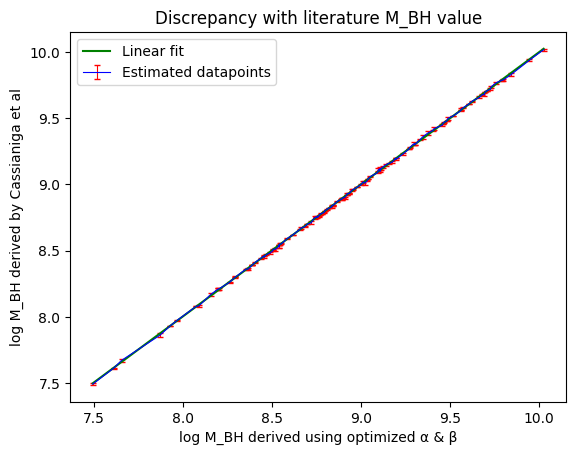

     M_BH using optimized parameters  Cassianiga_2013  Difference
12                          7.495410             7.49    0.005410
142                         7.612994             7.61    0.002994
47                          7.658178             7.67    0.011822
78                          7.873590             7.86    0.013590
2                           7.929806             7.93    0.000194
..                               ...              ...         ...
134                         9.793942             9.79    0.003942
28                          9.799336             9.79    0.009336
35                          9.842315             9.83    0.012315
13                          9.946937             9.94    0.006937
32                         10.026727            10.02    0.006727

[122 rows x 3 columns]
Mean error in predictions after using optimized alpha and beta: 0.005318103856649233


In [6]:
gamma = 2
df = pd.DataFrame({'L': data['logL30'], 'FWHM': data['logWMg']})   



df['L'] = pd.to_numeric(df['L'], errors='coerce')   
df['FWHM'] = pd.to_numeric(df['FWHM'], errors='coerce')
df = df.dropna(subset=['L', 'FWHM'])
L = 7+ df['L']   
FWHM = 10**(df['FWHM'])  

def log_M_BH(alpha,beta,gamma,L,FWHM):      
    return alpha + np.log10(10**L/1e44)*beta + np.log10(FWHM/1000)*gamma   

log_M_BH_array = np.zeros(len(L))


for index,value in enumerate(log_M_BH(alpha,beta,gamma,L,FWHM)):
    log_M_BH_array[index]= value


plot_df = pd.DataFrame({'M_BH using optimized parameters': log_M_BH_array, 'Cassianiga_2013': data['logMMg'][df.index].astype(float)}) # changed plot_df first column name everywhere 
plot_df = plot_df.sort_values(['M_BH using optimized parameters', 'Cassianiga_2013'], ascending=[True, True])
y_err = abs(plot_df['Cassianiga_2013']-plot_df['M_BH using optimized parameters'])

result = stats.linregress(plot_df['M_BH using optimized parameters'],plot_df['Cassianiga_2013'])


plt.xlabel('log M_BH derived using optimized α & β')  # changed xlabel
plt.ylabel('log M_BH derived by Cassianiga et al')
plt.title('Discrepancy with literature M_BH value')
plt.errorbar(x=plot_df['M_BH using optimized parameters'], y=plot_df['Cassianiga_2013'], yerr=y_err,color='blue', ecolor='red',lw=0.8,capsize=2,label='Estimated datapoints')
plt.plot(plot_df['M_BH using optimized parameters'], result.intercept + result.slope* plot_df['M_BH using optimized parameters'], color='green',label= 'Linear fit')
plt.legend()
plt.show()

plot_df['Difference'] = y_err   
table_df = plot_df[['M_BH using optimized parameters', 'Cassianiga_2013','Difference']]
print(table_df)
print('Mean error in predictions after using optimized alpha and beta: '+str(np.mean(plot_df['Difference'])))